In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline


In [19]:
# Import Data
df = pd.read_parquet('largeml.pq')

# Clean data
df['ret'] = pd.to_numeric(df['ret'], errors='coerce')  
df['yyyymm'] = df['yyyymm'].astype(int)
df['year_month'] = pd.to_datetime(df['yyyymm'], format='%Y%m')
df

,permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,...,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M,ret,year_month
0,10078,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.393044e-08,NaN,-0.118056,1986-06-01
1,10078,198607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.737205e-08,NaN,-0.039370,1986-07-01
2,10078,198609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.597698e-08,1.857281e-07,-0.008850,1986-09-01
3,10078,198610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.763825e-08,2.111030e-07,0.348214,1986-10-01
4,10078,198612,0.236302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.718727,NaN,5.878542e-09,8.619326e-08,0.109827,1986-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79141,93436,202206,0.088628,-2.813974,0.11705,0.115017,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.035232,NaN,0.707502,1.469368e-08,3.335508e-09,2.833702e-08,-0.111888,2022-06-01
79142,93436,202208,0.071943,-2.813974,0.11705,0.115017,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.021508,NaN,0.707502,1.432295e-08,3.931841e-09,2.786815e-08,-0.072489,2022-08-01
79143,93436,202209,0.074172,-2.813974,0.11705,0.115017,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.041281,NaN,0.707502,1.392299e-08,3.530526e-09,2.626227e-08,-0.037589,2022-09-01
79144,93436,202210,0.086471,-2.813974,0.11705,0.115017,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.025198,NaN,0.707502,1.386902e-08,5.036988e-09,2.783926e-08,-0.142168,2022-10-01


## 1 (a) Rank-Sort Characteristics Cross-Sectionally for Each Month

In [21]:
# Exclude certain columns
exclude_cols = ['permno', 'yyyymm', 'year_month', 'ret', 'date']
characteristic_cols = [col for col in df.columns if col not in exclude_cols]

# Create ranks
df_ranks = df[['permno', 'year_month', 'ret']].copy()

for char in characteristic_cols:
    df_ranks[char + "_rank"] = (
        df.groupby('year_month')[char]
          .rank(pct=True, na_option='keep') * 100
    )

df_ranks.head()

/var/folders/rp/39_89_qs577cxcr_85qc9jnw0000gn/T/ipykernel_51287/4054060536.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ranks[char + "_rank"] = (
/var/folders/rp/39_89_qs577cxcr_85qc9jnw0000gn/T/ipykernel_51287/4054060536.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ranks[char + "_rank"] = (
/var/folders/rp/39_89_qs577cxcr_85qc9jnw0000gn/T/ipykernel_51287/4054060536.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

,permno,year_month,ret,AM_rank,AOP_rank,AbnormalAccruals_rank,Accruals_rank,AccrualsBM_rank,Activism1_rank,Activism2_rank,...,retConglomerate_rank,roaq_rank,sfe_rank,sinAlgo_rank,skew1_rank,std_turn_rank,tang_rank,zerotrade12M_rank,zerotrade1M_rank,zerotrade6M_rank
0,10078,1986-06-01,-0.118056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.086420,NaN
1,10078,1986-07-01,-0.039370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.750000,NaN
2,10078,1986-09-01,-0.008850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,29.113924
3,10078,1986-10-01,0.348214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.750000,37.500000
4,10078,1986-12-01,0.109827,5.555556,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,70.0,NaN,2.439024,6.329114


/var/folders/rp/39_89_qs577cxcr_85qc9jnw0000gn/T/ipykernel_51287/2258434843.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_ret = tmp.groupby(date_col).apply(lambda g: np.sum(g["w"] * g[ret_col]))
/var/folders/rp/39_89_qs577cxcr_85qc9jnw0000gn/T/ipykernel_51287/2258434843.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_ret = tmp.groupby(date_col).apply(lambda g: np.sum(g["w"] * g[ret_col

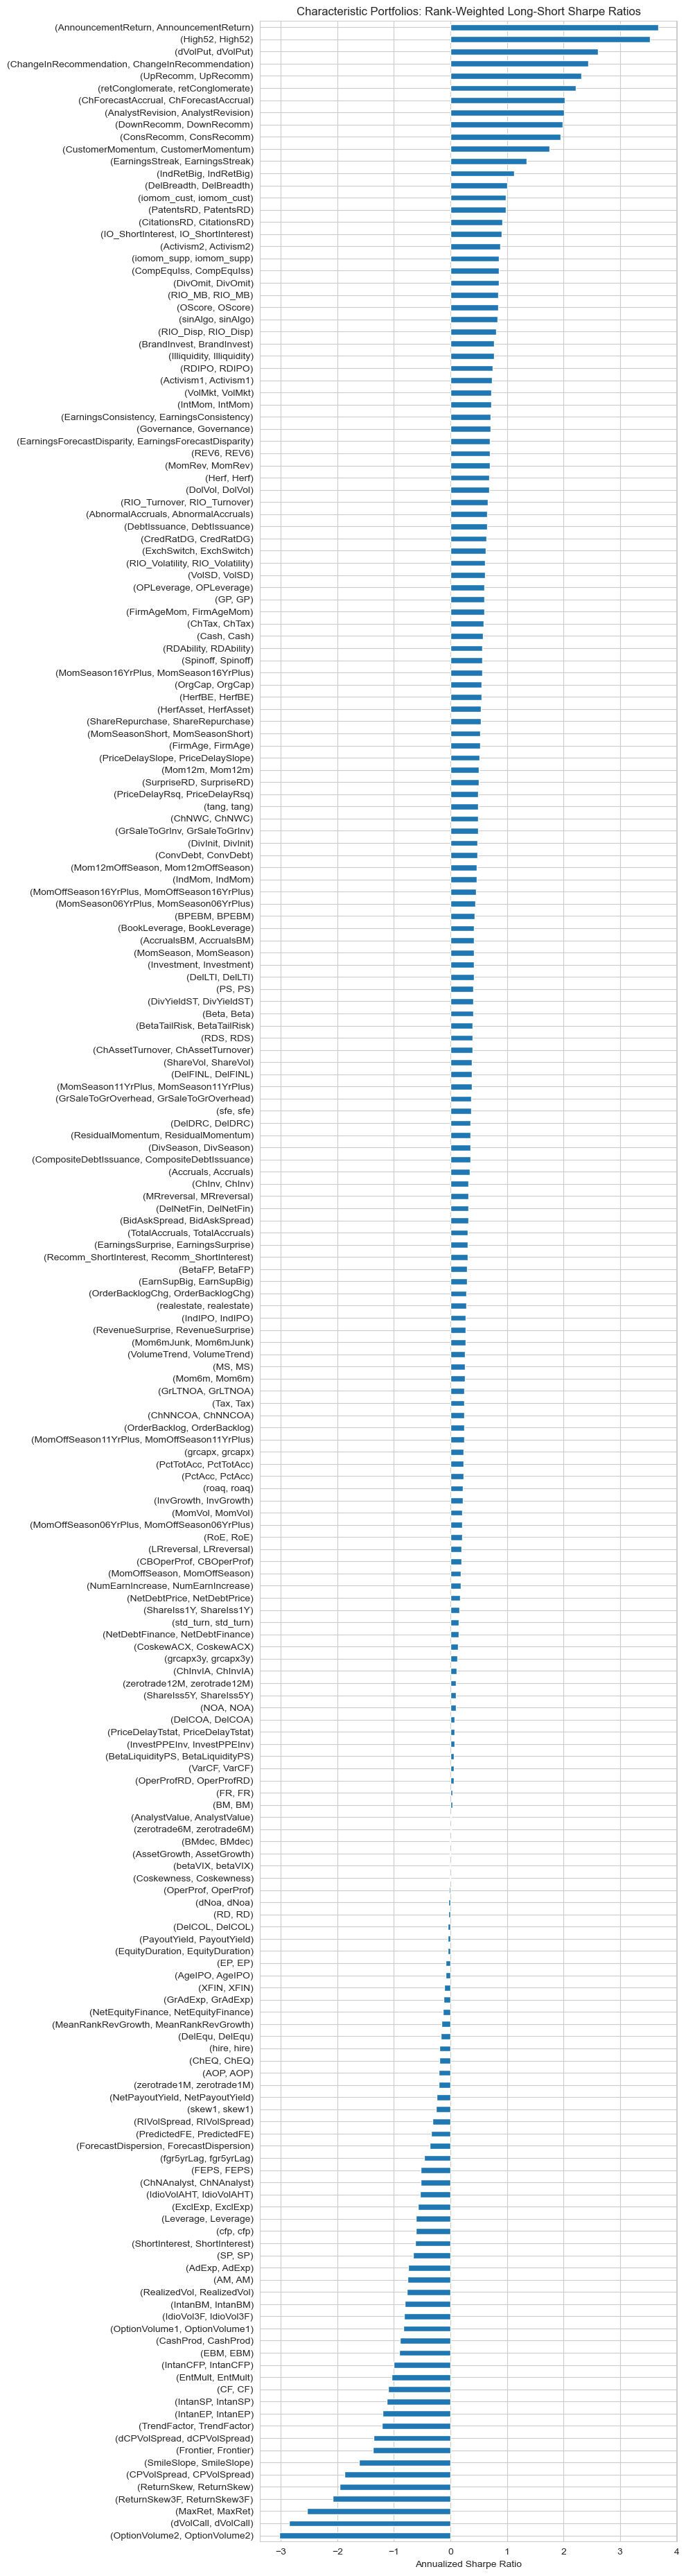

In [27]:
# Build portfolio return series for EVERY characteristic
port_rets = {}
for rc in rank_cols:
    port_rets[rc.replace("_rank","")] = characteristic_portfolio_returns(df_ranks, rc)

# Convert dict of Series to DataFrame, aligning by index
port_rets = pd.concat(port_rets, axis=1).sort_index()  
port_rets.head()

# Compute Annualized Sharpe ratios 
sharpe = port_rets.mean() / port_rets.std(ddof=1) * np.sqrt(12)
sharpe = sharpe.dropna().sort_values()

# Plot Sharpe ratios
plt.figure(figsize=(10, max(6, 0.18 * len(sharpe))))
sharpe.plot(kind="barh")
plt.xlabel("Annualized Sharpe Ratio")
plt.title("Characteristic Portfolios: Rank-Weighted Long-Short Sharpe Ratios")
plt.tight_layout()
plt.show()

### Analysis

Very few characteristics have a significantly positive sharpe ratio with only 13 characteristics with a sharpe ratio > 1. 

Characteristics related to information flow and short-term news, such as announcement returns, analyst recommendation changes, and forecast revisions, achieve the highest Sharpe ratios, indicating strong predictive power for future returns. In contrast, many traditional accounting-based characteristics exhibit Sharpe ratios close to zero, particularly in this large-cap sample.

## 1 (b) Adding Machine Learning Methods

In [ ]:
warnings.filterwarnings('ignore')

df_ml = df.copy()
df_ml = df_ml.sort_values('year_month').reset_index(drop=True)

# Only drop rows where returns are NaN 
df_ml = df_ml.dropna(subset=['ret']).copy()

# Define train/validation/test split points (by year-month)
unique_months = sorted(df_ml['year_month'].unique())
total_months = len(unique_months)

train_end_idx = int(20 * 12)  
val_end_idx = train_end_idx + int(12 * 12)  

train_end_date = unique_months[min(train_end_idx, len(unique_months)-1)]
val_end_date = unique_months[min(val_end_idx, len(unique_months)-1)]

# Create boolean masks for train/val/test
train_mask = df_ml['year_month'] <= train_end_date
val_mask = (df_ml['year_month'] > train_end_date) & (df_ml['year_month'] <= val_end_date)
test_mask = df_ml['year_month'] > val_end_date

# Extract data 
X_train_raw = df_ml.loc[train_mask, characteristic_cols].values
y_train = df_ml.loc[train_mask, 'ret'].values

X_val_raw = df_ml.loc[val_mask, characteristic_cols].values
y_val = df_ml.loc[val_mask, 'ret'].values

X_test_raw = df_ml.loc[test_mask, characteristic_cols].values
y_test = df_ml.loc[test_mask, 'ret'].values

# Fit and Transform data
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train_raw)
X_val = imputer.transform(X_val_raw)
X_test = imputer.transform(X_test_raw)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Helper function to evaluate model

def r2_oos_finance(y_true, y_pred, y_train_ref):
        sse_model = np.sum((y_true - y_pred) ** 2)
        if benchmark == "zero":
            sse_bench = np.sum((y_true) ** 2)
        elif benchmark == "train_mean":
            mu = np.mean(y_train_ref)
            sse_bench = np.sum((y_true - mu) ** 2)
        else:
            raise ValueError("benchmark must be 'train_mean' or 'zero'")
        return 1 - sse_model / sse_bench

def evaluate_model_oos(model_name, model, X_train, X_val, X_test, y_train, y_val, y_test, results_dict=None, benchmark="train_mean"):
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred   = model.predict(X_val)
    y_test_pred  = model.predict(X_test)

    # Metrics
    metrics = {
        # statistical (sklearn) R²
        "r2_train": r2_score(y_train, y_train_pred),
        "r2_val":   r2_score(y_val,   y_val_pred),
        "r2_test_sklearn": r2_score(y_test, y_test_pred),

        # finance OOS R² (Campbell–Thompson style)
        "r2_oos_val":  r2_oos_finance(y_val,  y_val_pred,  y_train),
        "r2_oos_test": r2_oos_finance(y_test, y_test_pred, y_train),

        # RMSE
        "rmse_train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "rmse_val":   np.sqrt(mean_squared_error(y_val,   y_val_pred)),
        "rmse_test":  np.sqrt(mean_squared_error(y_test,  y_test_pred)),

        "model": model
    }

    # Print results 
    print(f"\nMODEL: {model_name}")

    print("\nIn-Sample:")
    print(f"  R² (sklearn): {metrics['r2_train']:10.6f}")
    print(f"  RMSE:         {metrics['rmse_train']:10.6f}")

    print("\nValidation Performance:")
    print(f"  R² (sklearn): {metrics['r2_val']:10.6f}")
    print(f"  R²_OOS ({benchmark}): {metrics['r2_oos_val']:10.6f}")
    print(f"  RMSE:         {metrics['rmse_val']:10.6f}")

    print("\nOOS:")
    print(f"  R²_OOS ({benchmark}): {metrics['r2_oos_test']:10.6f}")
    print(f"  RMSE:         {metrics['rmse_test']:10.6f}")

    # Store
    if results_dict is not None:
        results_dict[model_name] = metrics

    return metrics

In [59]:
# Initialize results dictionary
results = {}

# OLS 
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)

evaluate_model_oos('OLS', ols_model, X_train_scaled, X_val_scaled, X_test_scaled, 
               y_train, y_val, y_test, results)

# Lasso
lasso_model = Lasso(0.1)
lasso_model.fit(X_train_scaled, y_train)
evaluate_model_oos('Lasso', lasso_model, X_train_scaled, X_val_scaled, X_test_scaled, 
               y_train, y_val, y_test, results)

# Ridge
ridge_model = Ridge(1.0)
ridge_model.fit(X_train_scaled, y_train)

evaluate_model_oos('Ridge', ridge_model, X_train_scaled, X_val_scaled, X_test_scaled, 
               y_train, y_val, y_test, results)

# Elastic Net
enet_model = ElasticNet(alpha=1e-3, l1_ratio=0.5, max_iter=20000, random_state=0)
enet_model.fit(X_train_scaled, y_train)

evaluate_model_oos('Elastic Net', enet_model, X_train_scaled, X_val_scaled, X_test_scaled, 
               y_train, y_val, y_test, results)



MODEL: OLS

In-Sample:
  R² (sklearn):   0.384288
  RMSE:           0.065318

Validation Performance:
  R² (sklearn):  -0.224200
  R²_OOS (train_mean):  -0.211415
  RMSE:           0.069899

OOS:
  R²_OOS (train_mean): -284.287536
  RMSE:           1.758341

MODEL: Lasso

In-Sample:
  R² (sklearn):   0.000000
  RMSE:           0.083243

Validation Performance:
  R² (sklearn):  -0.010553
  R²_OOS (train_mean):   0.000000
  RMSE:           0.063508

OOS:
  R²_OOS (train_mean):   0.000000
  RMSE:           0.104103

MODEL: Ridge

In-Sample:
  R² (sklearn):   0.384246
  RMSE:           0.065321

Validation Performance:
  R² (sklearn):  -0.217131
  R²_OOS (train_mean):  -0.204421
  RMSE:           0.069697

OOS:
  R²_OOS (train_mean): -279.744501
  RMSE:           1.744284

MODEL: Elastic Net

In-Sample:
  R² (sklearn):   0.375433
  RMSE:           0.065786

Validation Performance:
  R² (sklearn):   0.023351
  R²_OOS (train_mean):   0.033550
  RMSE:           0.062433

OOS:
  R²_OOS (train

{'r2_train': 0.3754334777985763,
 'r2_val': 0.02335082024074242,
 'r2_test_sklearn': -170.69370443425737,
 'r2_oos_val': np.float64(0.03354996596167936),
 'r2_oos_test': np.float64(-170.0588551156933),
 'rmse_train': np.float64(0.06578644523862248),
 'rmse_val': np.float64(0.06243319548526422),
 'rmse_test': np.float64(1.3615526829558446),
 'model': ElasticNet(alpha=0.001, max_iter=20000, random_state=0)}

In [ ]:

def grid_search_on_val(model_cls, param_grid, model_name):
    best = None
    for params in ParameterGrid(param_grid):
        model = model_cls(**params)
        model.fit(X_train_scaled, y_train)

        y_val_pred = model.predict(X_val_scaled)
        score = float(r2_oos_finance(y_val, y_val_pred, y_train))

        if (best is None) or (score > best["r2_oos_val"]):
            best = {"model_name": model_name, "params": params, "r2_oos_val": score, "model": model}

    print(model_name, "best:", best["params"], "val R2_OOS:", best["r2_oos_val"])
    return best

# Grids (adjust ranges if everything collapses to ~0)
ridge_best = grid_search_on_val(
    Ridge,
    {"alpha": np.logspace(-5, 5, 25)},
    "Ridge"
)

lasso_best = grid_search_on_val(
    Lasso,
    {"alpha": np.logspace(-6, -1, 25), "max_iter": [50000]},
    "Lasso"
)

enet_best = grid_search_on_val(
    ElasticNet,
    {"alpha": np.logspace(-6, -1, 25), "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0], "max_iter": [50000]},
    "ElasticNet"
)

# Evaluate best models using your existing function (stores into `results`)
evaluate_model_oos("Ridge(best)", ridge_best["model"], X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, results)
evaluate_model_oos("Lasso(best)", lasso_best["model"], X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, results)
evaluate_model_oos("ElasticNet(best)", enet_best["model"], X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, results)

In [ ]:
# Performing Grid Search Cross Validation for the models

# Pipeline
pipeline = Pipeline([
    ('OLS', ols_model),
    ('Lasso', lasso_model),
    ('Ridge', ridge_model),
    ('Elastic Net', enet_model),
])


# Parameter Grid
param_grid = {
    'classification__n_estimators': [200, 500],
    'classification__max_features': ['auto', 'sqrt', 'log2'],
    'classification__max_depth': [4, 5, 6, 7, 8],
    'classification__criterion': ['gini', 'entropy']
}


# Define the GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(10), scoring='roc_auc_ovr', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)